In [66]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
from scipy.stats import poisson

In [34]:
df_historical_data = pd.read_csv('fifa_worldcup_matches.csv')
df_fixture = pd.read_csv('fifa_worldcup_fixture.csv')
df_missing_data = pd.read_csv('fifa_worldcup_missing_data.csv')

In [35]:
df_fixture['home'] = df_fixture['home'].str.strip()
df_fixture['away'] = df_fixture['away'].str.strip()

In [36]:
df_missing_data.dropna(inplace=True)
df_historical_data = pd.concat([df_historical_data, df_missing_data], ignore_index=True)
df_historical_data.drop_duplicates(inplace=True)
df_historical_data.sort_values('year', inplace=True)
df_historical_data

,home,score,away,year
0,France,4–1,Mexico,1930
17,Uruguay,4–2,Argentina,1930
16,Uruguay,6–1,Yugoslavia,1930
15,Argentina,6–1,United States,1930
14,Paraguay,1–0,Belgium,1930
...,...,...,...,...
419,Brazil,2–0,Costa Rica,2018
420,Serbia,1–2,Switzerland,2018
421,Serbia,0–2,Brazil,2018
408,France,1–0,Peru,2018


In [37]:
# deleting match with walk over
delete_index = df_historical_data[df_historical_data['home'].str.contains('Sweden') &
                                  df_historical_data['away'].str.contains('Austria')].index

df_historical_data.drop(index=delete_index, inplace=True)

# cleanning score and home/away columns
df_historical_data['score'] = df_historical_data['score'].str.replace('[^\d–]', '', regex=True)
df_historical_data['home'] = df_historical_data['home'].str.strip() # clean blank spaces: Yugoslavia twice
df_historical_data['away'] = df_historical_data['away'].str.strip()

# splitting score columns into home and away goals and dropping score column
df_historical_data[['HomeGoals', 'AwayGoals']] = df_historical_data['score'].str.split('–', expand=True)
df_historical_data.drop('score', axis=1, inplace=True)

# renaming columns and changing data types
df_historical_data.rename(columns={'home': 'HomeTeam', 'away': 'AwayTeam', 
                                   'year':'Year'}, inplace=True)
df_historical_data = df_historical_data.astype({'HomeGoals': int, 'AwayGoals':int, 'Year': int})

# creating new column "totalgoals"
df_historical_data['TotalGoals'] = df_historical_data['HomeGoals'] + df_historical_data['AwayGoals']
df_historical_data

,HomeTeam,AwayTeam,Year,HomeGoals,AwayGoals,TotalGoals
0,France,Mexico,1930,4,1,5
17,Uruguay,Argentina,1930,4,2,6
16,Uruguay,Yugoslavia,1930,6,1,7
15,Argentina,United States,1930,6,1,7
14,Paraguay,Belgium,1930,1,0,1
...,...,...,...,...,...,...
419,Brazil,Costa Rica,2018,2,0,2
420,Serbia,Switzerland,2018,1,2,3
421,Serbia,Brazil,2018,0,2,2
408,France,Peru,2018,1,0,1


In [38]:
df_historical_data.to_csv('clean_fifa_worldcup_matches.csv',index=False)
df_fixture.to_csv('clean_fifa_worldcup_fixture.csv',index=False)

In [39]:
# verify number of matches per competition
years = [1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966, 1970, 1974,
         1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014,
         2018]

for year in years:
    print(year, len(df_historical_data[df_historical_data['Year']==year]))

1930 18
1934 17
1938 18
1950 22
1954 26
1958 35
1962 32
1966 32
1970 32
1974 38
1978 38
1982 52
1986 52
1990 52
1994 52
1998 64
2002 64
2006 64
2010 64
2014 64
2018 64


In [40]:
# verify data collected for a team
print(df_historical_data[df_historical_data['HomeTeam'].str.contains('Turkey')])
print(df_historical_data[df_historical_data['AwayTeam'].str.contains('Turkey')])

    HomeTeam     AwayTeam  Year  HomeGoals  AwayGoals  TotalGoals
83    Turkey  South Korea  1954          7          0           7
774   Turkey        China  2002          3          0           3
         HomeTeam AwayTeam  Year  HomeGoals  AwayGoals  TotalGoals
80   West Germany   Turkey  1954          4          1           5
84   West Germany   Turkey  1954          7          2           9
769        Brazil   Turkey  2002          2          1           3
287         Japan   Turkey  2002          0          1           1
292       Senegal   Turkey  2002          0          1           1
294        Brazil   Turkey  2002          1          0           1
295   South Korea   Turkey  2002          2          3           5
772    Costa Rica   Turkey  2002          1          1           2


In [42]:

# nation_position, club_position, player_positions
df = pd.read_csv('players_22.csv', low_memory=False)

# selecting column
df = df[['short_name', 'age', 'nationality_name', 'overall', 'potential',
         'club_name', 'value_eur', 'wage_eur', 'player_positions']]

# selecting only one position
df['player_positions'] = df['player_positions'].str.split(',', expand=True)[0]

# dropping nan
df.dropna(inplace=True)

In [43]:
players_missing_worldcup = ['K. Benzema', 'S. Mané', 'S. Agüero', 'Sergio Ramos', 'P. Pogba',
                            'M. Reus', 'Diogo Jota', 'A. Harit', 'N. Kanté', 'G. Lo Celso', 'Piqué']

# dropping injured players
drop_index = df[df['short_name'].isin(players_missing_worldcup)].index
df.drop(drop_index, axis=0, inplace=True)

In [44]:
teams_worldcup = [
    'Qatar', 'Brazil', 'Belgium', 'France', 'Argentina', 'England', 'Spain', 'Portugal',
    'Mexico', 'Netherlands', 'Denmark', 'Germany', 'Uruguay', 'Switzerland', 'United States', 'Croatia',
    'Senegal', 'Iran', 'Japan', 'Morocco', 'Serbia', 'Poland', 'South Korea', 'Tunisia',
    'Cameroon', 'Canada', 'Ecuador', 'Saudi Arabia', 'Ghana', 'Wales', 'Costa Rica', 'Australia'
]

In [45]:
# filtering only national teams in the world cup
df = df[df['nationality_name'].isin(teams_worldcup)]

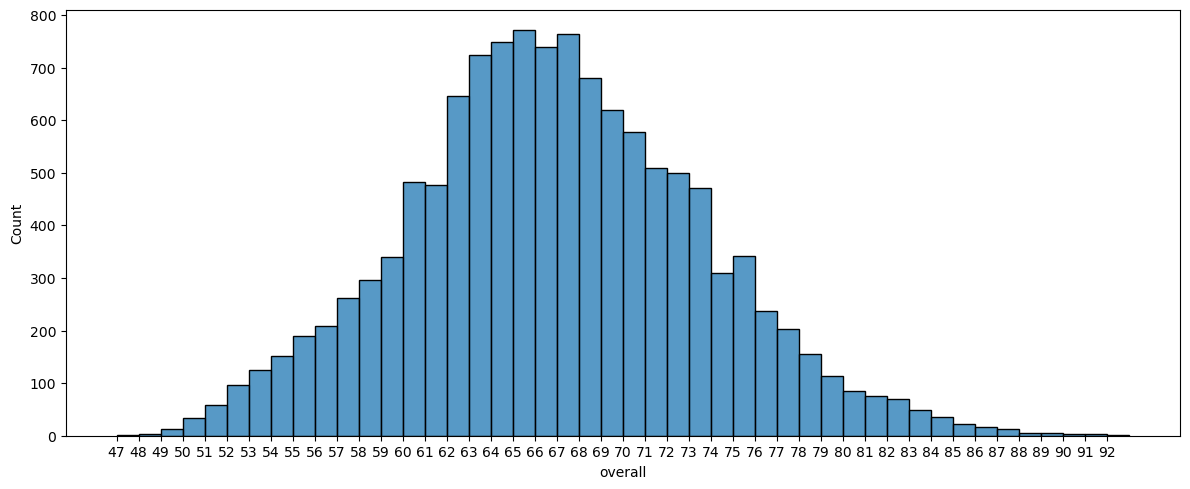

In [46]:
import numpy as np
fig, ax = plt.subplots(figsize=(12, 5), tight_layout=True)

sns.histplot(df, x='overall', binwidth=1)

bins = np.arange(df['overall'].min(), df['overall'].max(), 1)
plt.xticks(bins)
plt.show()

In [47]:
df.drop_duplicates('player_positions')

,short_name,age,nationality_name,overall,potential,club_name,value_eur,wage_eur,player_positions
0,L. Messi,34,Argentina,93,93,Paris Saint-Germain,78000000.0,320000.0,RW
1,R. Lewandowski,32,Poland,92,92,FC Bayern München,119500000.0,270000.0,ST
3,Neymar Jr,29,Brazil,91,91,Paris Saint-Germain,129000000.0,270000.0,LW
4,K. De Bruyne,30,Belgium,91,91,Manchester City,125500000.0,350000.0,CM
7,M. Neuer,35,Germany,90,90,FC Bayern München,13500000.0,86000.0,GK
14,Casemiro,29,Brazil,89,89,Real Madrid CF,88000000.0,310000.0,CDM
15,V. van Dijk,29,Netherlands,89,89,Liverpool,86000000.0,230000.0,CB
28,Bruno Fernandes,26,Portugal,88,89,Manchester United,107500000.0,250000.0,CAM
41,P. Dybala,27,Argentina,87,88,Juventus,93000000.0,160000.0,CF
44,T. Alexander-Arnold,22,England,87,92,Liverpool,114000000.0,150000.0,RB


In [93]:

print(df_best_players[['short_name', 'nationality_name', 'name_nationality']].head())


          short_name nationality_name         name_nationality
0           L. Messi        Argentina           L. Messi (ARG)
1     R. Lewandowski           Poland     R. Lewandowski (POL)
2  Cristiano Ronaldo         Portugal  Cristiano Ronaldo (POR)
3          Neymar Jr           Brazil          Neymar Jr (BRA)
4       K. De Bruyne          Belgium       K. De Bruyne (BEL)


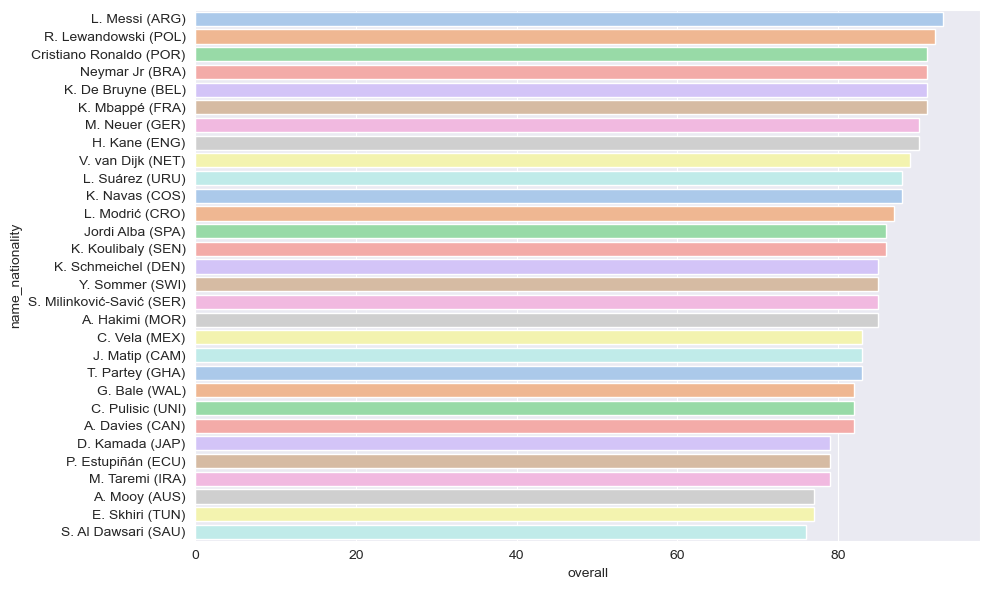

In [95]:

df_best_players = df.copy()
df_best_players = df_best_players.drop_duplicates('nationality_name').reset_index(drop=True)
country_short = df_best_players['nationality_name'].str.extract('(^\w{3})', expand=False).str.upper()
df_best_players['name_nationality'] = df_best_players['short_name'] + ' (' + country_short + ')'

fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)

sns.barplot(data=df_best_players, x='overall', y='name_nationality',
            palette=sns.color_palette('pastel'))
plt.show()


In [57]:
def best_squad(nationality):
    df_best_squad = df.copy()
    df_best_squad = df_best_squad.groupby(['nationality_name', 'player_positions']).head(2)
    df_best_squad = df_best_squad[df_best_squad['nationality_name']==nationality].sort_values(['player_positions', 'overall', 'potential'], ascending=False)
    return df_best_squad

In [58]:
best_squad('Brazil')

,short_name,age,nationality_name,overall,potential,club_name,value_eur,wage_eur,player_positions
191,Gabriel Jesus,24,Brazil,83,87,Manchester City,52500000.0,150000.0,ST
268,Richarlison,24,Brazil,82,87,Everton,46500000.0,100000.0,ST
5069,Paolinho Leima,21,Brazil,70,70,Clube Atlético Mineiro,1700000.0,12000.0,RWB
8031,Jadenilson Baia,33,Brazil,67,67,Sport Club Corinthians Paulista,525000.0,9000.0,RWB
656,Rodrygo,20,Brazil,79,88,Real Madrid CF,38500000.0,115000.0,RW
646,David Neres,24,Brazil,79,83,Ajax,25000000.0,19000.0,RW
271,Raphinha,24,Brazil,82,87,Leeds United,46000000.0,89000.0,RM
318,Lucas Moura,28,Brazil,81,81,Tottenham Hotspur,26000000.0,105000.0,RM
311,Danilo,29,Brazil,81,81,Juventus,22500000.0,83000.0,RB
484,Maikel Catarino,25,Brazil,80,80,Sport Club Corinthians Paulista,21000000.0,33000.0,RB


In [59]:
average_overall = [best_squad(team)['overall'].mean() for team in teams_worldcup]

df_average_overall = pd.DataFrame({'Teams': teams_worldcup, 'AVG_Overall': average_overall})
df_average_overall = df_average_overall.dropna()
df_average_overall = df_average_overall.sort_values('AVG_Overall', ascending=False)
df_average_overall

,Teams,AVG_Overall
6,Spain,82.400000
7,Portugal,81.733333
5,England,81.700000
1,Brazil,81.666667
3,France,81.000000
4,Argentina,80.566667
11,Germany,80.433333
2,Belgium,79.034483
9,Netherlands,78.758621
8,Mexico,77.727273


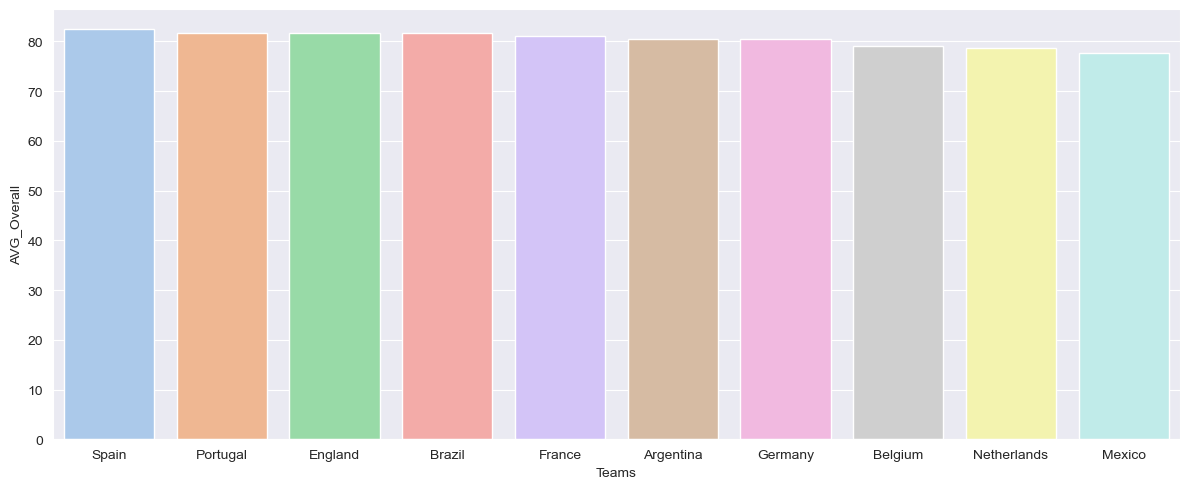

In [89]:
fig, ax = plt.subplots(figsize=(12, 5), tight_layout=True)

# Ensure you pass the DataFrame as the 'data' argument
sns.barplot(data=df_average_overall[:10], x='Teams', y='AVG_Overall',
            palette=sns.color_palette('pastel'))
plt.show()


In [61]:
def best_lineup(nationality, lineup):
    lineup_count = [lineup.count(i) for i in lineup]

    df_lineup = pd.DataFrame({'position': lineup, 'count': lineup_count})
    positions_non_repeated = df_lineup[df_lineup['count'] <= 1]['position'].values
    positions_repeated = df_lineup[df_lineup['count'] > 1]['position'].values

    df_squad = best_squad(nationality)

    df_lineup = pd.concat([
        df_squad[df_squad['player_positions'].isin(positions_non_repeated)].drop_duplicates('player_positions', keep='first'),
        df_squad[df_squad['player_positions'].isin(positions_repeated)]]
    )
    return df_lineup[['short_name', 'overall', 'club_name', 'player_positions']]

In [62]:
dict_formation = {
    '4-3-3': ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CM', 'CAM', 'RW', 'ST', 'LW'],
    '4-4-2': ['GK', 'RB', 'CB', 'CB', 'LB', 'RM', 'CM', 'CM', 'LM', 'ST', 'ST'],
    '4-2-3-1': ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CDM', 'CAM', 'CAM', 'CAM', 'ST'],
}

In [63]:
for index, row in df_average_overall[:9].iterrows():
    max_average = None
    for key, values in dict_formation.items():
        average = best_lineup(row['Teams'], values)['overall'].mean()
        if max_average is None or average>max_average:
            max_average = average
            formation = key
    print(row['Teams'], formation, max_average)

Spain 4-2-3-1 85.1
Portugal 4-2-3-1 84.9
England 4-4-2 84.45454545454545
Brazil 4-3-3 84.81818181818181
France 4-2-3-1 83.9
Argentina 4-3-3 83.54545454545455
Germany 4-2-3-1 84.1
Belgium 4-3-3 82.54545454545455
Netherlands 4-4-2 82.54545454545455


In [64]:
# best_lineup('Spain', dict_formation['4-2-3-1'])
# best_lineup('Argentina', dict_formation['4-3-3'])
best_lineup('Brazil', dict_formation['4-3-3'])

,short_name,overall,club_name,player_positions
191,Gabriel Jesus,83,Manchester City,ST
656,Rodrygo,79,Real Madrid CF,RW
311,Danilo,81,Juventus,RB
3,Neymar Jr,91,Paris Saint-Germain,LW
153,Alex Sandro,83,Juventus,LB
18,Ederson,89,Manchester City,GK
190,Arthur,83,Juventus,CM
14,Casemiro,89,Real Madrid CF,CDM
189,Ronaldo Cabrais,83,Grêmio,CAM
39,Marquinhos,87,Paris Saint-Germain,CB


In [96]:
dict_table = pickle.load(open('dict_table','rb'))
df_historical_data = pd.read_csv('clean_fifa_worldcup_matches.csv')
df_fixture = pd.read_csv('clean_fifa_worldcup_fixture.csv')

In [97]:
df_home = df_historical_data[['HomeTeam', 'HomeGoals', 'AwayGoals']]
df_away = df_historical_data[['AwayTeam', 'HomeGoals', 'AwayGoals']]

df_home = df_home.rename(columns={'HomeTeam':'Team', 'HomeGoals': 'GoalsScored', 'AwayGoals': 'GoalsConceded'})
df_away = df_away.rename(columns={'AwayTeam':'Team', 'HomeGoals': 'GoalsConceded', 'AwayGoals': 'GoalsScored'})

df_team_strength = pd.concat([df_home, df_away], ignore_index=True).groupby(['Team']).mean()
df_team_strength

,GoalsScored,GoalsConceded
Team,,
Algeria,1.000000,1.461538
Angola,0.333333,0.666667
Argentina,1.691358,1.148148
Australia,0.812500,1.937500
Austria,1.482759,1.620690
...,...,...
Uruguay,1.553571,1.321429
Wales,0.800000,0.800000
West Germany,2.112903,1.241935


In [98]:
def predict_points(home, away):
    if home in df_team_strength.index and away in df_team_strength.index:
        # goals_scored * goals_conceded
        lamb_home = df_team_strength.at[home,'GoalsScored'] * df_team_strength.at[away,'GoalsConceded']
        lamb_away = df_team_strength.at[away,'GoalsScored'] * df_team_strength.at[home,'GoalsConceded']
        prob_home, prob_away, prob_draw = 0, 0, 0
        for x in range(0,11): #number of goals home team
            for y in range(0, 11): #number of goals away team
                p = poisson.pmf(x, lamb_home) * poisson.pmf(y, lamb_away)
                if x == y:
                    prob_draw += p
                elif x > y:
                    prob_home += p
                else:
                    prob_away += p
        
        points_home = 3 * prob_home + prob_draw
        points_away = 3 * prob_away + prob_draw
        return (points_home, points_away)
    else:
        return (0, 0)

In [99]:
print(predict_points('England', 'United States'))
print(predict_points('Argentina', 'Mexico'))
print(predict_points('Qatar (H)', 'Ecuador')) # Qatar vs Team X -> 0 points to both

(2.2356147635326007, 0.5922397535606193)
(2.3129151525530505, 0.5378377125059863)
(0, 0)


In [100]:

df_fixture_group_48 = df_fixture[:48].copy()
df_fixture_knockout = df_fixture[48:56].copy()
df_fixture_quarter = df_fixture[56:60].copy()
df_fixture_semi = df_fixture[60:62].copy()
df_fixture_final = df_fixture[62:].copy()

In [101]:

for group in dict_table:
    teams_in_group = dict_table[group]['Team'].values
    df_fixture_group_6 = df_fixture_group_48[df_fixture_group_48['home'].isin(teams_in_group)]
    for index, row in df_fixture_group_6.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away)
        dict_table[group].loc[dict_table[group]['Team'] == home, 'Pts'] += points_home
        dict_table[group].loc[dict_table[group]['Team'] == away, 'Pts'] += points_away

    dict_table[group] = dict_table[group].sort_values('Pts', ascending=False).reset_index()
    dict_table[group] = dict_table[group][['Team', 'Pts']]
    dict_table[group] = dict_table[group].round(0)

In [102]:
dict_table['Group A']

,Team,Pts
0,Netherlands,4.0
1,Senegal,2.0
2,Ecuador,2.0
3,Qatar (H),0.0


In [103]:
df_fixture_knockout

,home,score,away,year
48,Winners Group A,Match 49,Runners-up Group B,2022
49,Winners Group C,Match 50,Runners-up Group D,2022
50,Winners Group D,Match 52,Runners-up Group C,2022
51,Winners Group B,Match 51,Runners-up Group A,2022
52,Winners Group E,Match 53,Runners-up Group F,2022
53,Winners Group G,Match 54,Runners-up Group H,2022
54,Winners Group F,Match 55,Runners-up Group E,2022
55,Winners Group H,Match 56,Runners-up Group G,2022


In [104]:
for group in dict_table:
    group_winner = dict_table[group].loc[0, 'Team']
    runners_up = dict_table[group].loc[1, 'Team']
    df_fixture_knockout.replace({f'Winners {group}':group_winner,
                                 f'Runners-up {group}':runners_up}, inplace=True)

df_fixture_knockout['winner'] = '?'
df_fixture_knockout

,home,score,away,year,winner
48,Netherlands,Match 49,Wales,2022,?
49,Argentina,Match 50,Denmark,2022,?
50,France,Match 52,Poland,2022,?
51,England,Match 51,Senegal,2022,?
52,Germany,Match 53,Belgium,2022,?
53,Brazil,Match 54,Uruguay,2022,?
54,Croatia,Match 55,Spain,2022,?
55,Portugal,Match 56,Switzerland,2022,?


In [105]:
def get_winner(df_fixture_updated):
    for index, row in df_fixture_updated.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away)
        if points_home > points_away:
            winner = home
        else:
            winner = away
        df_fixture_updated.loc[index, 'winner'] = winner
    return df_fixture_updated

In [106]:
get_winner(df_fixture_knockout)

,home,score,away,year,winner
48,Netherlands,Match 49,Wales,2022,Netherlands
49,Argentina,Match 50,Denmark,2022,Argentina
50,France,Match 52,Poland,2022,France
51,England,Match 51,Senegal,2022,England
52,Germany,Match 53,Belgium,2022,Germany
53,Brazil,Match 54,Uruguay,2022,Brazil
54,Croatia,Match 55,Spain,2022,Spain
55,Portugal,Match 56,Switzerland,2022,Portugal


In [107]:

def update_table(df_fixture_round_1, df_fixture_round_2):
    for index, row in df_fixture_round_1.iterrows():
        winner = df_fixture_round_1.loc[index, 'winner']
        match = df_fixture_round_1.loc[index, 'score']
        df_fixture_round_2.replace({f'Winners {match}':winner}, inplace=True)
    df_fixture_round_2['winner'] = '?'
    return df_fixture_round_2

In [108]:
update_table(df_fixture_knockout, df_fixture_quarter)


,home,score,away,year,winner
56,Germany,Match 58,Brazil,2022,?
57,Netherlands,Match 57,Argentina,2022,?
58,Spain,Match 60,Portugal,2022,?
59,England,Match 59,France,2022,?


In [109]:

get_winner(df_fixture_quarter)

,home,score,away,year,winner
56,Germany,Match 58,Brazil,2022,Brazil
57,Netherlands,Match 57,Argentina,2022,Netherlands
58,Spain,Match 60,Portugal,2022,Portugal
59,England,Match 59,France,2022,France


In [110]:
update_table(df_fixture_quarter, df_fixture_semi)


,home,score,away,year,winner
60,Netherlands,Match 61,Brazil,2022,?
61,France,Match 62,Portugal,2022,?


In [111]:
get_winner(df_fixture_semi)


,home,score,away,year,winner
60,Netherlands,Match 61,Brazil,2022,Brazil
61,France,Match 62,Portugal,2022,France


In [112]:
update_table(df_fixture_semi, df_fixture_final)


,home,score,away,year,winner
62,Losers Match 61,Match 63,Losers Match 62,2022,?
63,Brazil,Match 64,France,2022,?


In [113]:
get_winner(df_fixture_final)


,home,score,away,year,winner
62,Losers Match 61,Match 63,Losers Match 62,2022,Losers Match 62
63,Brazil,Match 64,France,2022,Brazil
